<a href="https://colab.research.google.com/github/AlexKostjuk/dz_17/blob/master/dz_17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 218.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 68.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


In [2]:
!pip install darts prophet statsmodels


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.7/169.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.0/981.0 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.1 MB/s eta 0:00:00


In [3]:
!pip install pmdarima


In [4]:
!pip install torch --extra-index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118


In [1]:
import torch
from torch.cuda.amp import autocast

In [ ]:
import os
os.kill(os.getpid(), 9)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import ExponentialSmoothing, AutoARIMA, NBEATSModel
from pmdarima import auto_arima
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from google.colab import files


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
frb = pd.read_csv('/content/drive/MyDrive/T10Y2Y.csv', delimiter=',')


In [5]:
frb.head()

,observation_date,T10Y2Y
0,1976-06-01,0.68
1,1976-06-02,0.71
2,1976-06-03,0.70
3,1976-06-04,0.77
4,1976-06-07,0.79


In [6]:
frb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739 entries, 0 to 12738
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  12739 non-null  object 
 1   T10Y2Y            12203 non-null  float64
dtypes: float64(1), object(1)
memory usage: 199.2+ KB


In [7]:
frb['observation_date'] = pd.to_datetime(frb['observation_date'])
frb = frb.dropna()

In [8]:
frb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12203 entries, 0 to 12738
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   observation_date  12203 non-null  datetime64[ns]
 1   T10Y2Y            12203 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 286.0 KB


In [9]:
train_size = int(len(frb) * 0.9)
train_frb = frb[:train_size]
test_frb = frb[train_size:]

In [10]:
future_period = 1000


In [11]:
last_date = frb['observation_date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1),
                            periods=future_period,
                            freq='B')

Модель 1: Darts (NBEATS)

In [38]:

date_range = pd.date_range(start=train_frb['observation_date'].min(),
                          end=train_frb['observation_date'].max(),
                          freq='B')
train_frb_full = pd.DataFrame({'observation_date': date_range})
train_frb_full = train_frb_full.merge(train_frb, on='observation_date', how='left')

train_frb_full['T10Y2Y'] = train_frb_full['T10Y2Y'].ffill().bfill()

train_series = TimeSeries.from_dataframe(train_frb_full, 'observation_date', 'T10Y2Y', freq='B')

print("NaN in train_frb_full['T10Y2Y']:", train_frb_full['T10Y2Y'].isna().sum())

darts_model = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    generic_architecture=True,
    num_stacks=2,
    num_blocks=3,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    random_state=42,
    pl_trainer_kwargs={
        "accelerator": "gpu",
        "devices": [0],
    } if torch.cuda.is_available() else {}
)
darts_model.fit(train_series)

with autocast():
    darts_pred = darts_model.predict(len(test_frb) + future_period)
darts_pred_values = darts_pred.values().flatten()
darts_pred_test = darts_pred_values[:len(test_frb)]
darts_pred_future = darts_pred_values[len(test_frb):]

print("NaN in darts_pred_values before handling:", np.isnan(darts_pred_values).sum())
darts_pred_test = np.nan_to_num(darts_pred_test, nan=train_frb['T10Y2Y'].mean())
darts_pred_future = np.nan_to_num(darts_pred_future, nan=train_frb['T10Y2Y'].mean())

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 4.8 M  | train
-------------------------------------------------------------
4.8 M     Trainable params
2.7 K     Non-trainable params
4.8 M     Total params
19.347    Total estimated m

NaN in train_frb_full['T10Y2Y']: 0


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
<ipython-input-38-07b75f9c2e41>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Використовуємо змішану точність для прогнозу
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

NaN in darts_pred_values before handling: 0


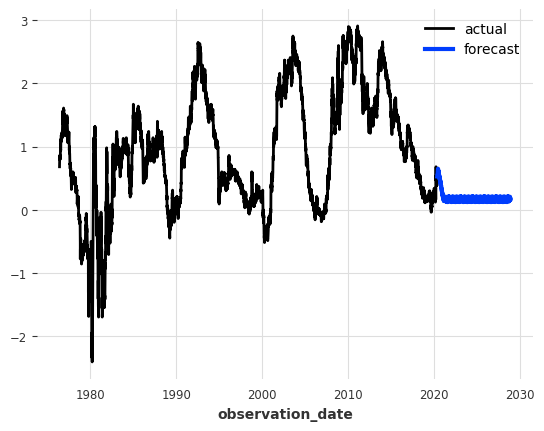

In [39]:
train_series.plot(label='actual')
darts_pred.plot(label='forecast', lw=3)
plt.legend()

працює прогноз візуально більш менш правдивий

перевірка на нан

In [40]:
print("NaN in darts_pred_values before handling:", np.isnan(darts_pred_values).sum())
darts_pred_values = np.nan_to_num(darts_pred_values, nan=train_frb['T10Y2Y'].mean())

NaN in darts_pred_values before handling: 0


Модель 2: Prophet

тут використаємо лінійну інтерполяцію для заповнення пропущених значень та пограємось з тижневою та річною сезонністю

In [33]:

prophet_frb = train_frb.rename(columns={'observation_date': 'ds', 'T10Y2Y': 'y'})
prophet_frb_full = pd.DataFrame({'ds': date_range})
prophet_frb_full = prophet_frb_full.merge(prophet_frb, on='ds', how='left')
prophet_frb_full['y'] = prophet_frb_full['y'].interpolate(method='linear')

prophet_model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,  # для тижневої сезонності
    yearly_seasonality=True,  # для річної сезонності
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=1.0,
    n_changepoints=200
)

#американські свята
prophet_model.add_country_holidays(country_name='US')

prophet_model.fit(prophet_frb_full)

future_dates_prophet = pd.DataFrame({'ds': pd.concat([pd.Series(test_frb['observation_date']),
                                                     pd.Series(future_dates)]).reset_index(drop=True)})
prophet_pred = prophet_model.predict(future_dates_prophet)
prophet_pred_values = prophet_pred['yhat'].values
prophet_pred_test = prophet_pred_values[:len(test_frb)]
prophet_pred_future = prophet_pred_values[len(test_frb):]
prophet_pred_test = np.nan_to_num(prophet_pred_test, nan=train_frb['T10Y2Y'].mean())
prophet_pred_future = np.nan_to_num(prophet_pred_future, nan=train_frb['T10Y2Y'].mean())


DEBUG:cmdstanpy:input tempfile: /tmp/tmpn4166f_y/d202ovz9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn4166f_y/n8nv1st3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75053', 'data', 'file=/tmp/tmpn4166f_y/d202ovz9.json', 'init=/tmp/tmpn4166f_y/n8nv1st3.json', 'output', 'file=/tmp/tmpn4166f_y/prophet_model5h3g4s1p/prophet_model-20250331074952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:50:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Модель 3: SARIMA (з auto_arima)

In [17]:
sarima_model = auto_arima(
    train_frb['T10Y2Y'],
    seasonal=True,
    m=5,
    stepwise=True,
    trace=True
)

sarima_pred = sarima_model.predict(n_periods=len(test_frb) + future_period)
sarima_pred_values = sarima_pred.values
sarima_pred_test = sarima_pred_values[:len(test_frb)]
sarima_pred_future = sarima_pred_values[len(test_frb):]
sarima_pred_test = np.nan_to_num(sarima_pred_test, nan=train_frb['T10Y2Y'].mean())
sarima_pred_future = np.nan_to_num(sarima_pred_future, nan=train_frb['T10Y2Y'].mean())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=-36157.691, Time=29.65 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=-36156.011, Time=1.10 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=-36158.521, Time=3.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=-36158.351, Time=3.29 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[5]             : AIC=-36158.011, Time=0.41 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[5] intercept   : AIC=-36160.432, Time=0.76 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,1)[5] intercept   : AIC=-36158.517, Time=2.29 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[5] intercept   : AIC=-36156.505, Time=3.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[5] intercept   : AIC=-36160.005, Time=2.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[5] intercept   : AIC=-36158.387, Time=3.57 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[5] intercept   : AIC=-36160.267, Time=1.68 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[5] intercept   : AIC=-36158.083, Time=6.58 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[5]             : AIC=-36162.432, Time=0.28 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[5]             : AIC=-36160.520, Time=0.89 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,1)[5]             : AIC=-36160.516, Time=0.84 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[5]             : AIC=-36158.504, Time=1.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[5]             : AIC=-36162.005, Time=1.60 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[5]             : AIC=-36160.387, Time=1.41 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[5]             : AIC=-36162.266, Time=1.00 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[5]             : AIC=-36160.083, Time=1.43 sec

Best model:  ARIMA(1,1,0)(0,0,0)[5]          
Total fit time: 66.398 seconds


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


точно щоб не було нан

In [45]:
actual = test_frb['T10Y2Y'].values



print("NaN in actual:", np.isnan(actual).sum())
print("NaN in darts_pred_test:", np.isnan(darts_pred_test).sum())
print("NaN in prophet_pred_test:", np.isnan(prophet_pred_test).sum())
print("NaN in sarima_pred_test:", np.isnan(sarima_pred_test).sum())

metrics = {
    'Model': ['Darts', 'Prophet', 'SARIMA'],
    'MAE': [
        mean_absolute_error(actual, darts_pred_test),
        mean_absolute_error(actual, prophet_pred_test),
        mean_absolute_error(actual, sarima_pred_test)
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(actual, darts_pred_test)),
        np.sqrt(mean_squared_error(actual, prophet_pred_test)),
        np.sqrt(mean_squared_error(actual, sarima_pred_test))
    ]
}

NaN in actual: 0
NaN in darts_pred_test: 0
NaN in prophet_pred_test: 0
NaN in sarima_pred_test: 0


In [42]:
results_frb = pd.DataFrame(metrics)
print(results_frb)

     Model       MAE      RMSE
0    Darts  0.553921  0.669901
1  Prophet  0.695119  0.843199
2   SARIMA  0.673076  0.788314


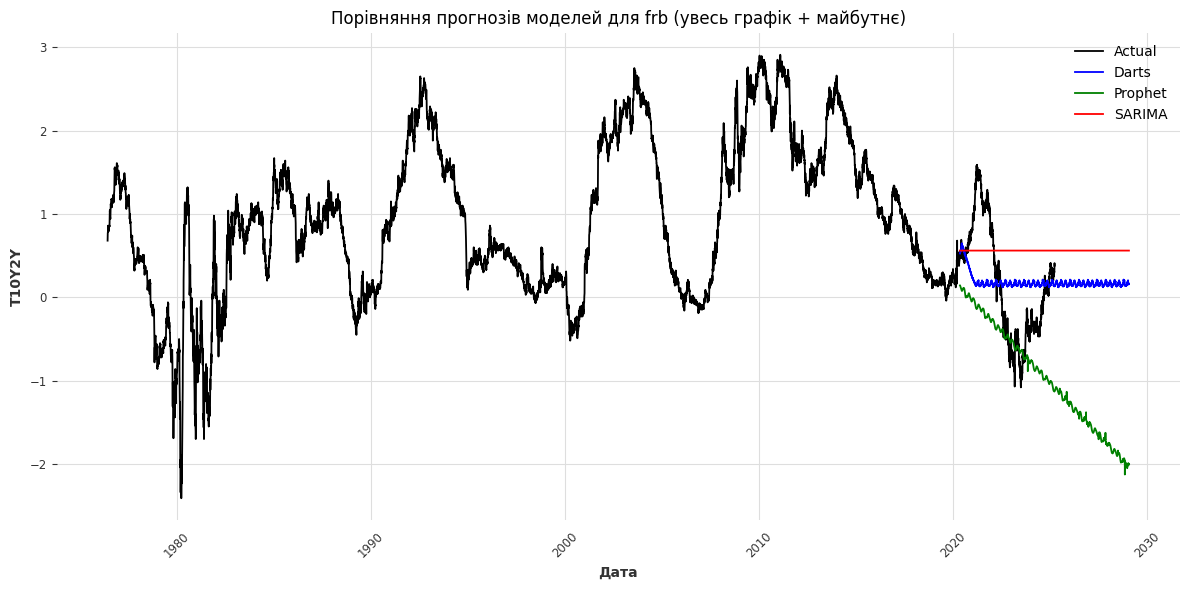

In [44]:
all_dates = pd.concat([pd.Series(frb['observation_date']), pd.Series(future_dates)]).reset_index(drop=True)
actual_all = frb['T10Y2Y'].values

darts_full_pred = np.concatenate([np.full(len(train_frb), np.nan), darts_pred_test, darts_pred_future])
prophet_full_pred = np.concatenate([np.full(len(train_frb), np.nan), prophet_pred_test, prophet_pred_future])
sarima_full_pred = np.concatenate([np.full(len(train_frb), np.nan), sarima_pred_test, sarima_pred_future])

plt.figure(figsize=(12, 6))
plt.plot(all_dates[:len(actual_all)], actual_all, label='Actual', color='black')
plt.plot(all_dates, darts_full_pred, label='Darts', color='blue')
plt.plot(all_dates, prophet_full_pred, label='Prophet', color='green')
plt.plot(all_dates, sarima_full_pred, label='SARIMA', color='red')
plt.legend()
plt.title('Порівняння прогнозів моделей для frb (увесь графік + майбутнє)')
plt.xlabel('Дата')
plt.ylabel('T10Y2Y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

на мій погляд найкращий прогноз дала перша модель а третя найгірший розглянемо більш детально перші 2 моделі

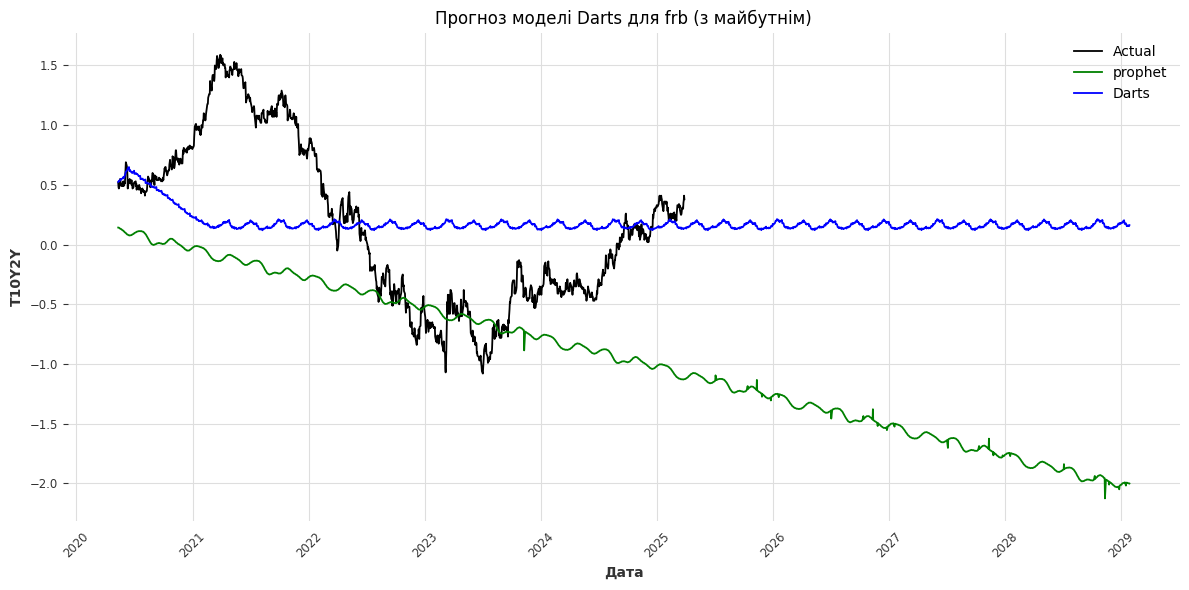

In [43]:
all_dates = pd.concat([pd.Series(test_frb['observation_date']), pd.Series(future_dates)]).reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(test_frb['observation_date'], actual, label='Actual', color='black')
plt.plot(all_dates, np.concatenate([prophet_pred_test, prophet_pred_future]), label='prophet', color='green')

plt.plot(all_dates, np.concatenate([darts_pred_test, darts_pred_future]), label='Darts', color='blue')
plt.legend()
plt.title('Прогноз моделі Darts для frb (з майбутнім)')
plt.xlabel('Дата')
plt.ylabel('T10Y2Y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


тут маємо цікаіий результат що скоріш за все тренд на спадання підтвердеться але буде не таким стрімким як у другій моделі тож прогноз скоріж за все буде щось середне між двома моделями